<a href="https://colab.research.google.com/github/Mihir-Singhal/ML-projects/blob/main/Image_Recognition_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Index


- 1. Import Packages and Function
- 2. Load the Datasets
    - 2.1 Preventing Data Leakage
    - 2.2 Preparing Images
    - 2.3 Visualizing Images
- 3. Class Imbalence
    - 3.1 Addressing Class Imbalance
    - 3.2 Computing and Visualizing Class Imbalance
    - 3.3 Dealing with Class Imbalance
    - 3.4 Calculating the weighted loss
- 4. Model Creation
    - 4.1 Evaluating Pretrained Weights
    - 4.2 Training i.e. Fine Tuning
- 5. Prediction and Evaluation
    - 5.1 Comparing ROC Curves
    - 5.2 Comparing AUROC Values


## 1. Import Packages and Functions

Using following packages:
- `numpy` and `pandas` is what we'll use to manipulate our data
- `matplotlib.pyplot` and `seaborn` will be used to produce plots for visualization
- `util` will provide the locally defined utility functions that have been provided for this assignment

Will also use several modules from the `keras` framework for building deep learning models.

In [ ]:

import random
import cv2
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity

random.seed(a=None, version=2)

set_verbosity(INFO)


def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std


def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=320, W=320):

    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam


def compute_gradcam(model, img, image_dir, df, labels, selected_labels,
                    layer_name='bn'):
    preprocessed_input = load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)

    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False),
                       cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1


def get_roc_curve(labels, predicted_vals, generator, when = ''):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve ' + when)
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals


Using TensorFlow backend.


In [ ]:

!pip install -q efficientnet
import efficientnet.tfkeras as efn


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

from keras.models import load_model


# from tensorflow.keras.applications import DenseNet121
import tensorflow as tf
import tensorflow.keras.layers as L
# import tensorflow.keras.layers as Layers

In [ ]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
IMAGE_SIZE=[128, 128]
EPOCHS = 20
# BATCH_SIZE = 8 * strategy.num_replicas_in_sync
BATCH_SIZE = 64


## 2. Load the Datasets

 108,948 frontal-view X-ray images of 32,717 unique patients.


In [ ]:
train_df_main = pd.read_csv('../input/chestxray8-dataframe/train_df.csv')

train_df_main.drop(['No Finding'], axis = 1, inplace = True)
labels = train_df_main.columns[2:-1]
labels

Index(['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration',
       'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening',
       'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split
train_df, discard = train_test_split(train_df_main, test_size = 0.7, random_state = 1993)

train_and_valid_set, test_set = train_test_split(train_df, test_size = 0.2, random_state = 1993)
train_set, valid_set = train_test_split(train_and_valid_set, test_size = 0.2, random_state = 1993)

<a name='2-1'></a>
### 2.1 Preventing Data Leakage



### Checking Data Leakage
Function to check whether there is leakage between two datasets. Make sure there are no patients in the test set that are also present in either the train or validation sets.

In [1]:

def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs

    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """

    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)
    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups)>0
    return leakage

### 2.2 Preparing Images

- Use of ImageDataGenerator class from the Keras framework, which allows us to build a "generator" for images specified in a dataframe.
- This class also provides support for basic data augmentation such as random horizontal flipping of images.
- Use the generator to transform the values in each batch so that their mean is $0$ and their standard deviation is 1.
    - This will facilitate model training by standardizing the input distribution.
- The generator also converts single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels.

Here
1. We normalize the mean and standard deviation of the data
3. We shuffle the input after each epoch.
4. We set the image size to be **320px by 320px

In [ ]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.

    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """
    print("getting train generator...")
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True,
        shear_range=0.1,
        zoom_range=0.15,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.05,
        horizontal_flip=True,
        vertical_flip = False,
        fill_mode = 'reflect')


    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))

    return generator



#### Build a separate generator for valid and test sets


In [ ]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.

    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=image_dir,
        x_col="FilePath",
        y_col=labels,
        class_mode="raw",
        batch_size=sample_size,
        shuffle=True,
        target_size=(target_w, target_h))

    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)

    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [ ]:
train_generator = get_train_generator(df = train_set,
                                      image_dir = None,
                                      x_col = "FilePath",
                                      y_cols = labels,
                                      batch_size=BATCH_SIZE,
                                      target_w = IMAGE_SIZE[0],
                                      target_h = IMAGE_SIZE[1]
                                      )

valid_generator, test_generator= get_test_and_valid_generator(valid_df = valid_set,
                                                              test_df = test_set,
                                                              train_df = train_set,
                                                              image_dir = None,
                                                              x_col = "FilePath",
                                                              y_cols = labels,
                                                              batch_size = BATCH_SIZE,
                                                              target_w = IMAGE_SIZE[0],
                                                              target_h = IMAGE_SIZE[1])

getting train generator...
Found 21526 validated image filenames.
getting train and valid generators...
Found 21526 validated image filenames.
Found 5382 validated image filenames.
Found 6728 validated image filenames.


### 2.3 Visualizing Images

 `get_label()` that will produce the class of the image as the appended string of the labels.

100%|██████████| 8/8 [00:00<00:00, 56.31it/s]


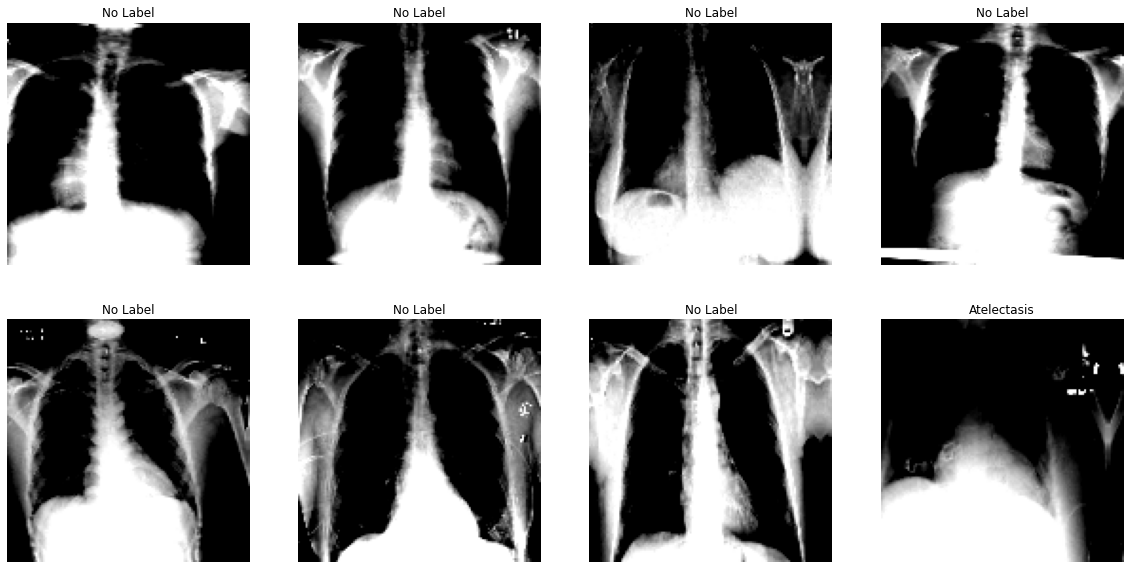

In [ ]:

def get_label(y):
    """
    Returns the appended label list of the given set.

    y(list) the one hot vector list containing the label encoding.
    """
    ret_labels = []
    i = 0
    for idx in y:
        if idx:
            ret_labels.append(labels[i])
        i += 1
    if not ret_labels:
        return 'No Label'
    else:
        return '|'.join(ret_labels)

#get one batch of images from the imageset
x, y = train_generator.__getitem__(0)



#show a set of images along with the labels appended at the top as title.
fig=plt.figure(figsize=(20, 10))
columns = 4; rows =2
for i in tqdm(range(1, columns*rows +1)):
    fig.add_subplot(rows, columns, i)
    plt.imshow(x[i-1], cmap = 'gray')
    plt.title(get_label(y[i-1]))
    plt.axis(False)
    fig.add_subplot

## 3. Class Imbalance

### 3.1 Addressing Class Imbalance
One of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets. Let's plot the frequency of each of the labels in our dataset:

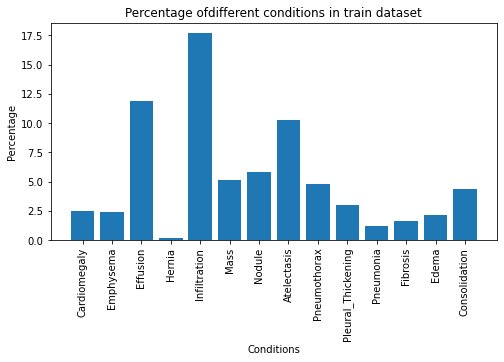

In [ ]:
plt.figure(figsize=(8,4))
plt.xticks(rotation = 90)
plt.bar(labels, train_generator.labels.sum(axis = 0)/train_generator.n * 100)
plt.title('Percentage ofdifferent conditions in train dataset')
plt.xlabel('Conditions')
plt.ylabel('Percentage')
plt.show()

### 3.2 Computing and Visualizing Class Imbalance
Let's take the whole dataset and check the number of the different conditions identified among the x-rays. After that we plot the relative percentage of existance of different conditions in the image.

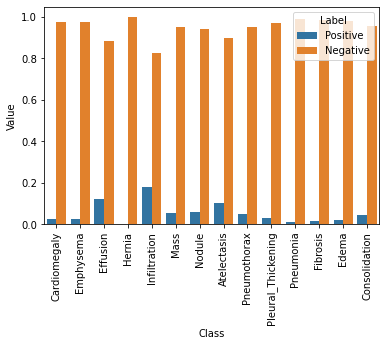

In [ ]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    # total number of patients (rows)
    N = labels.shape[0]
    positive_frequencies = (labels.sum(axis = 0))/N
    negative_frequencies = 1.0 - positive_frequencies

    return positive_frequencies, negative_frequencies


# calulating and plotting the imbalanced classes
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

### 3.3 Balancing Classes

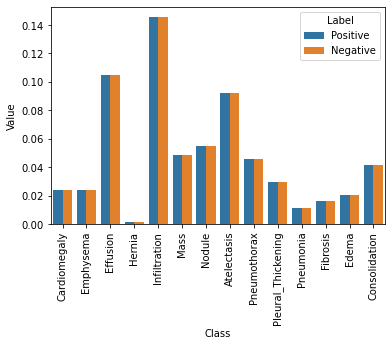

In [ ]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights
pos_weights


data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

### 3.4 Calculating the weighted loss



In [ ]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)

    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value.

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        return loss

    return weighted_loss

# 4. Model Creation
Then we will load the pretrained weights and have a look at the **ROC** curve and **AUROC** values for the different diagonostic categories.

In [ ]:
with strategy.scope():
    model = tf.keras.Sequential([
        efn.EfficientNetB1(
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet',
            include_top=False),
        L.GlobalAveragePooling2D(),
        L.Dense(1024, activation = 'relu'),
        L.Dense(len(labels), activation='sigmoid')
    ])

model.compile(
    optimizer=tf.keras.optimizers.Adam( learning_rate=1e-4, amsgrad=False),
    #loss = 'binary_crossentropy',
    loss = get_weighted_loss(pos_weights, neg_weights),
    metrics = ['accuracy']
)
model.summary()
model.load_weights('../input/nih-chest-xray-training-weights/efficent_net_b1_trained_weights.h5')

27164672/27164032 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b1 (Model)      (None, 4, 4, 1280)        6575232   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 14)                14350     
Total params: 7,901,326
Trainable params: 7,839,278
Non-trainable params: 62,048
_________________________________________________________________


### Learning rate

In [ ]:
def build_lrfn(lr_start=0.000002, lr_max=0.00010,
               lr_min=0, lr_rampup_epochs=8,
               lr_sustain_epochs=0, lr_exp_decay=.8):

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [ ]:
history = model.fit_generator(train_generator,
                              validation_data=valid_generator,
                              steps_per_epoch=len(train_generator),
                              validation_steps=len(valid_generator),
                              epochs = EPOCHS,
                              callbacks=[lr_schedule]
                             )


Epoch 00001: LearningRateScheduler reducing learning rate to 2e-06.
Epoch 1/20
337/337 [==============================] - 698s 2s/step - loss: 0.7618 - accuracy: 0.1427 - val_loss: 0.8070 - val_accuracy: 0.1531 - lr: 2.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 1.425e-05.
Epoch 2/20
337/337 [==============================] - 596s 2s/step - loss: 0.7592 - accuracy: 0.1521 - val_loss: 0.8039 - val_accuracy: 0.1682 - lr: 1.4250e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6500000000000004e-05.
Epoch 3/20
337/337 [==============================] - 559s 2s/step - loss: 0.7522 - accuracy: 0.1643 - val_loss: 0.7952 - val_accuracy: 0.1752 - lr: 2.6500e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 3.875000000000001e-05.
Epoch 4/20
337/337 [==============================] - 586s 2s/step - loss: 0.7452 - accuracy: 0.1712 - val_loss: 0.7928 - val_accuracy: 0.2062 - lr: 3.8750e-05

Epoch 00005: LearningRateScheduler reducing le

In [ ]:
predicted_vals_before = model.predict_generator(test_generator, steps = len(test_generator))

In [ ]:


history = model.fit_generator(train_generator,
                              validation_data=valid_generator,
                              steps_per_epoch=len(train_generator),
                              validation_steps=len(valid_generator),
                              epochs = EPOCHS,
                              callbacks=[lr_schedule]
                             )


Epoch 00001: LearningRateScheduler reducing learning rate to 2e-06.
Epoch 1/20
337/337 [==============================] - 661s 2s/step - loss: 0.5174 - accuracy: 0.2460 - val_loss: 0.9059 - val_accuracy: 0.1869 - lr: 2.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 1.425e-05.
Epoch 2/20
337/337 [==============================] - 629s 2s/step - loss: 0.5195 - accuracy: 0.2465 - val_loss: 0.9031 - val_accuracy: 0.1906 - lr: 1.4250e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6500000000000004e-05.
Epoch 3/20
337/337 [==============================] - 637s 2s/step - loss: 0.5214 - accuracy: 0.2438 - val_loss: 0.9083 - val_accuracy: 0.1830 - lr: 2.6500e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 3.875000000000001e-05.
Epoch 4/20
337/337 [==============================] - 626s 2s/step - loss: 0.5180 - accuracy: 0.2453 - val_loss: 0.9505 - val_accuracy: 0.1877 - lr: 3.8750e-05

Epoch 00005: LearningRateScheduler reducing le

## Training Summary

In [ ]:
def visualize_training(history, lw = 3):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['accuracy'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(fontsize = 'x-large')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.show()

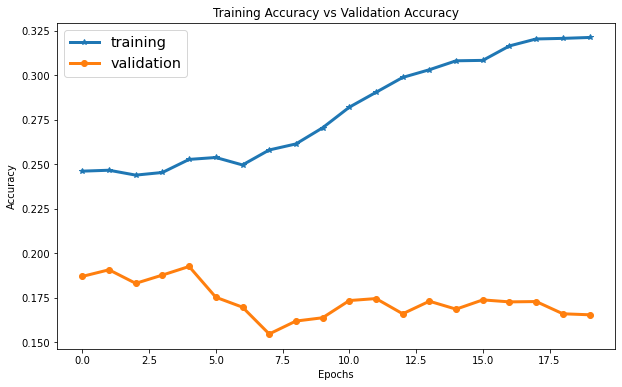

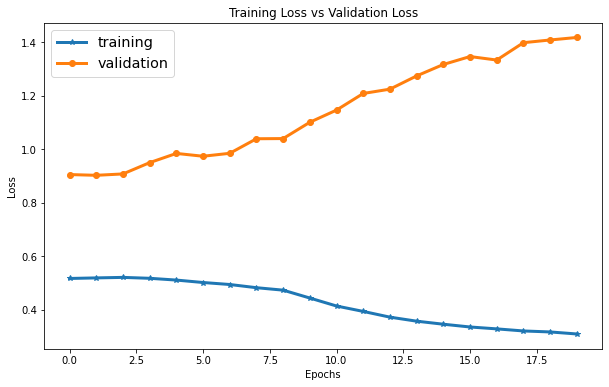

In [ ]:
visualize_training(history)

## 5. Prediction and Evaluation
The predict_generator function to generate the predictions for the images in our test set.

### 5.1 Comparing ROC Curves

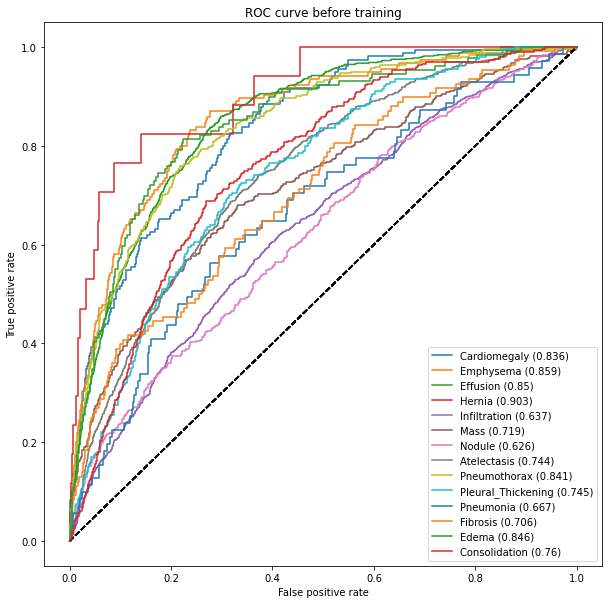

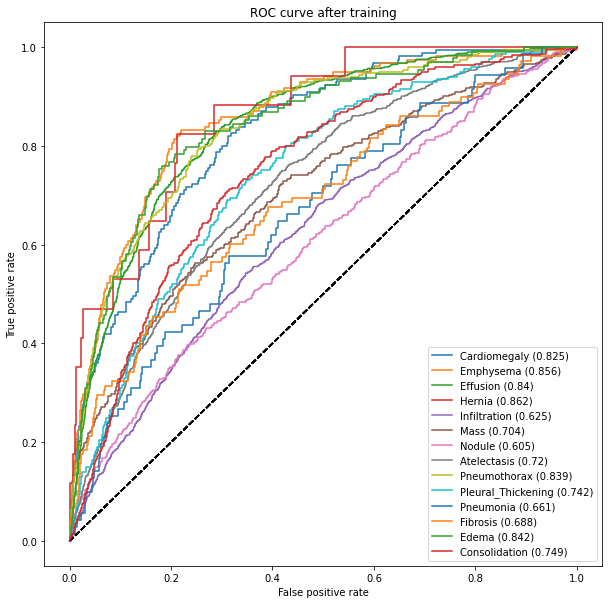

In [ ]:
predicted_vals_after = model.predict_generator(test_generator, steps = len(test_generator))
auc_rocs_before =get_roc_curve(labels, predicted_vals_before, test_generator, when = 'before training')
auc_rocs_after = get_roc_curve(labels, predicted_vals_after, test_generator, when = 'after training')

<a name='5-3'></a>
## 5.2 Comparing AUROC Values


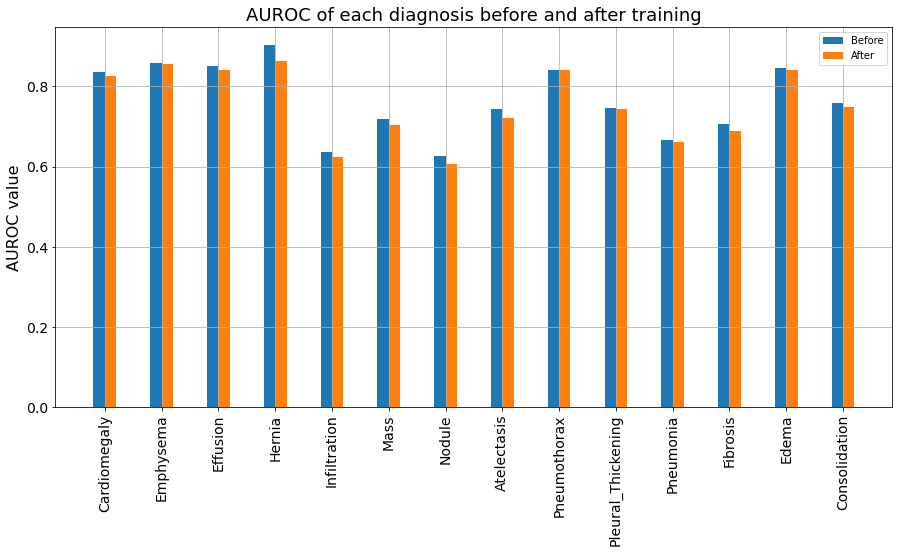

In [ ]:
ind = np.arange(len(labels))
plt.figure(figsize=(15,7))
width = 0.2
plt.bar(ind, auc_rocs_before , width, label='Before')
plt.bar(ind + width, auc_rocs_after, width, label='After')
plt.ylabel('AUROC value', fontsize = 16)
plt.title('AUROC of each diagnosis before and after training', fontsize = 18)
plt.xticks(ind + width / 2, labels, rotation = 90, fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(loc='best')
plt.grid(True)
plt.show()